# Vortex Plots

Plots with heterokaryon samples.

**Inputs:**
1. List of peak sets
2. Config of samples, bigwig path and class of sample (each class will have same plot styling). If sample belongs to ATAC dataset, old cluster ID else NA.
3. For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [8]:
library(ggplot2)
library(patchwork)
library(reshape2)
library(rtracklayer)
library(scales)
library(viridis)
library(matrixStats)
library(ggrastr)
library(raster)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

## Loading Inputs

### Configs

In [283]:
vortex_config = read.table("./vortex_tracks_config.tsv", sep='\t', header=T, stringsAsFactors = T)
vortex_config$path = as.character(vortex_config$path)
vortex_config$short_name = gsub(" ", "\n", vortex_config$short_name)
vortex_config

title,short_name,old_cluster,type,group,width,path
<fct>,<chr>,<int>,<fct>,<int>,<int>,<chr>
Fibroblast,Fib,5,ATAC,1,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx5/signal/rep1/cluster_idx5.fc.signal.bigwig
MRC5 (CC),Co-cult,NA,ATAC2,1,2000,/oak/stanford/groups/akundaje/projects/heterokaryon/ATAC-Seq/Batch1/outputs/CC_hg38/cromwell-executions/atac/8a3ac2dd-002d-41c5-88d6-a8c0787309dd/call-macs2_signal_track/shard-0/execution/CC_rep1.R1.merged.nodup.bam.hg38.renamed.tn5.fc.signal.bigwig
Early Intermediate,Early,8,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx8/signal/rep1/cluster_idx8.fc.signal.bigwig
Het 3hr,Het 3hr,NA,ATAC2,2,2000,/oak/stanford/groups/akundaje/projects/heterokaryon/ATAC-Seq/Batch1/outputs/3hr_hg38/cromwell-executions/atac/e221a4b1-0f64-46b0-b387-afba4d8cc6bc/call-macs2_signal_track_pooled/execution/3hr_rep1.R1.merged.nodup.bam.hg38.renamed.tn5.pooled.fc.signal.bigwig
Intermediate,Int,2,ATAC,3,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx2/signal/rep1/cluster_idx2.fc.signal.bigwig
Pre-iPSC (D12),Pre-iPSC (D12),7,ATAC,3,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx7/signal/rep1/cluster_idx7.fc.signal.bigwig
Het 16hr,Het 16hr,NA,ATAC2,3,2000,/oak/stanford/groups/akundaje/projects/heterokaryon/ATAC-Seq/Batch1/outputs/16hr_hg38/cromwell-executions/atac/9b526f13-a88c-47c0-b1a1-4506d1eafe95/call-macs2_signal_track_pooled/execution/16hr_rep1.R1.merged.nodup.bam.hg38.renamed.tn5.pooled.fc.signal.bigwig
Het 48hr,Het 48hr,NA,ATAC2,4,2000,/oak/stanford/groups/akundaje/projects/heterokaryon/ATAC-Seq/Batch1/outputs/48hr_hg38/cromwell-executions/atac/1d8176cd-22d5-4459-9ee6-2afcc757b7e2/call-macs2_signal_track_pooled/execution/48hr_rep1.R1.merged.nodup.bam.hg38.renamed.tn5.pooled.fc.signal.bigwig
Pre-iPSC (D14),Pre-iPSC (D14),1,ATAC,4,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx1/signal/rep1/cluster_idx1.fc.signal.bigwig


In [3]:
# manually add if required
# vortex_config[15,] = c("iPSC", 18, "ATAC", 4, 2000, 
#                        "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx18/signal/rep1/cluster_idx18.fc.signal.bigwig")

# vortex_config$old_cluster = as.integer(vortex_config$old_cluster)
# vortex_config$width = as.integer(vortex_config$width)

In [234]:
peak_set_config = read.table("./vortex_peak_set_config.tsv", stringsAsFactors = F, comment.char = '', sep='\t', header=T)
peak_set_config

title,group,path
<chr>,<int>,<chr>
C10,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx10.bed
C13,2,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx13.bed
C18,3,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx18.bed


In [120]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#A6D854,Pre-iPSC,14
2,2,#F0A118,Intermediate,12
3,3,#E85F6D,Fibroblast-like,3
4,4,#006658,Neural-like,8
5,5,#B03743,Fibroblast,1
6,6,#CF175A,Fibroblast-like,4
7,7,#78A824,Pre-iPSC,13
8,8,#F4D5CD,Intermediate,11
9,9,#D4B81C,Intermediate,9


### Peak Sets

In [235]:
peak_sets = list()
SUBSAMPLE = 20

for (i in seq(nrow(peak_set_config))) {
    peak_sets[[i]] = import(peak_set_config[i, "path"])
    peak_sets[[i]] = peak_sets[[i]][seq(1,length(peak_sets[[i]]),SUBSAMPLE)]
}

In [236]:
# manually load peaks
# peak_sets = list()
# peak_sets[[1]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed")
# peak_sets[[1]] = peak_sets[[1]][seq(1,length(peak_sets[[1]]),5)]

# peak_sets[[2]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.atac.hg38.bed")
# peak_sets[[2]] = peak_sets[[2]][seq(1,length(peak_sets[[2]]),5)]

# peak_sets[[3]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed")
# peak_sets[[3]] = peak_sets[[3]][seq(1,length(peak_sets[[3]]),5)]

In [237]:
peak_set_lens = list()

for (i in seq(length(peak_sets))) {
    peak_set_lens[[i]] = length(peak_sets[[i]])
}

peak_set_lens

sum(unlist(peak_set_lens))

[[1]]
[1] 1286

[[2]]
[1] 730

[[3]]
[1] 1243

[1] 3259

### Fetch Data from BigWigs

In [238]:
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [239]:
matrices = list()

In [240]:
for (i in seq(length(peak_sets))) {
    matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = get_matrix_from_bigwig(vortex_config[j, "path"], 
                                                    resize(peak_sets[[i]], width=vortex_config[j, "width"], fix='center'))
    }
}

## Compute Orders for Each Peak Set and Reorder

In [241]:
# samples which will be used to decide peak order (based on mean signal across all)
ROW_ORDER_TYPE = "ATAC2" # Hets

In [242]:
peak_set_orders = list()

In [243]:
for (i in seq(length(peak_sets))) {
    tmp_matrix = do.call(cbind, matrices[[i]][vortex_config$type %in% ROW_ORDER_TYPE])
    peak_set_orders[[i]] = order(rowSums(tmp_matrix))
}

In [244]:
rm(tmp_matrix)

In [245]:
peak_set_orders[[1]][1:10]

[1]    1  427  560 1231  129  419  690  883  965  511

In [246]:
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = matrices[[i]][[j]][peak_set_orders[[i]], ]
    }
}

## Smooth Samples

In [247]:
y_lims = list()

In [248]:
# find limits for clipping
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)    
    
    y_lims[[type]] = as.numeric(quantile(tmp_matrices, 0.98))
    
}

In [249]:
rm(tmp_matrices)

In [250]:
y_lims

[[1]]
[1] 7.91811

[[2]]
[1] 2.90407

In [251]:
# clip matrices to y_lim
clipped_matrices = list()

for (i in seq(length(peak_sets))) {
    clipped_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        clipped_matrices[[i]][[j]] = matrices[[i]][[j]]
        clipped_matrices[[i]][[j]][clipped_matrices[[i]][[j]] > y_lims[[vortex_config[j, "type"]]]] = y_lims[[vortex_config[j, "type"]]]
    }
}

In [252]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [253]:
# mean downsample matrices along X dimension 
# ENSURE DIM_AFTER_SAMPLE is a divisor of all widths
DIM_AFTER_SAMPLE = 200

smoothed_matrices = list()
for (i in seq(length(peak_sets))) {
    smoothed_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
            stopifnot(ncol(clipped_matrices[[i]][[j]])%%DIM_AFTER_SAMPLE==0)

            scale_factor = ncol(clipped_matrices[[i]][[j]])/DIM_AFTER_SAMPLE
            smoothed_matrices[[i]][[j]] = (1/scale_factor)*(clipped_matrices[[i]][[j]]%*%create_sum_matrix(ncol(clipped_matrices[[i]][[j]]), scale_factor))
    }
}

In [254]:
# mean downsample along samples (y-axis)

Y_SUBSAMPLE_FACTOR = 5
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
            smoothed_matrices[[i]][[j]] = t((1/Y_SUBSAMPLE_FACTOR)*(t(smoothed_matrices[[i]][[j]])%*%create_sum_matrix(nrow(smoothed_matrices[[i]][[j]]), 
                                                                                                                     Y_SUBSAMPLE_FACTOR)))
    }
}

In [255]:
dim(smoothed_matrices[[1]][[1]])

[1] 257 200

In [256]:
# additional smoothing
# for (i in seq(length(peak_sets))) {
#     for (j in seq(nrow(vortex_config))) {
#         smoothed_matrices[[i]][[j]] =  as.matrix(focal(raster(smoothed_matrices[[i]][[j]]), matrix(1, 3, 3), mean, pad = T, padValue = 0))
#     }
# }

## Decide Limits and Colour Schemes

In [257]:
COLORSCALES = list(scale_fill_viridis_c(option="B", oob=squish), 
               scale_fill_distiller(palette="Blues", oob=squish, direction=1),
               scale_fill_distiller(palette="Reds", oob=squish, direction=1))

In [258]:
# decide limits for each type
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, smoothed_matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)
    
    low = quantile(tmp_matrices, 0.01)
    high = quantile(tmp_matrices, 0.999)
    
    COLORSCALES[[k]]$limits = c(low, high)
    
}

In [259]:
rm(tmp_matrices)

In [260]:
for (k in seq(length(unique(vortex_config$type)))) {
    print(COLORSCALES[[k]]$limits)
}

        1%      99.9% 
0.06458708 7.04041069 
      1%    99.9% 
0.000000 2.713364 


## Plotting

In [284]:
plot_vortex <- function(bwmatrix, color_scale_with_limits,
                       title=NULL, clust_name=NULL, ticks=NULL) {
    # ticks is a number and if not null, will make ticks at
    # left and right end with +ticks kb and -ticks kb
    
    melted = melt(bwmatrix)
    
    plot <- ggplot(melted, aes(x=Var2, y= Var1, fill=value)) +
#     geom_tile_rast() + # kinda slow, geom_raster is faster and smaller files
#     geom_tile() +
    geom_raster() +
    color_scale_with_limits + 
    scale_y_continuous(expand = c(0, 0)) + # this removes whitespace between plot and border
    theme_void() 
    
    if (!is.null(title)) {
        plot = plot + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5))
    }
    
    if (!is.null(clust_name)) {
        plot = plot + ylab(sprintf("%s ", clust_name)) + 
             theme(axis.title.y = element_text())
    }
    
    if (!is.null(ticks)) {
        plot = plot + scale_x_continuous(breaks = c(1, ncol(bwmatrix)/2, ncol(bwmatrix)), 
                                         labels = c(sprintf("-%dkb", ticks), "",
                                                    sprintf("+%dkb", ticks)),
                                         expand = c(0,0)) # this removes whitespace between plot and border
        plot = plot + theme(axis.ticks.length=unit(.25, "cm"),
                           axis.text.x = element_text(size=10))
    }
                                         
    else {
        plot = plot + 
               scale_x_continuous(expand=c(0,0)) + # this removes whitespace between plot and border
               theme(axis.ticks.x=element_blank(),
                    axis.text.x = element_blank(),) 
    }
    
    plot = plot + theme(legend.position = "none",             
            axis.title.x = element_blank(),
#             axis.text.y=element_blank(),
            axis.line=element_blank(),
            axis.ticks.y=element_blank(),
            plot.margin = unit(c(0,2,0,2), "pt"), # right tick label was clipping
          panel.border = element_rect(colour = "black", fill=NA, size=0.5))
    
    plot
}

In [285]:
# bwm_clipped = bwm
# bwm_clipped[bwm_clipped>quantile(bwm, 0.99)] = quantile(bwm, 0.99)
# bwm_clipped_ordered = bwm_clipped[order(rowMeans(bwm)), ]
# bwm_clipped_smoothed = as.matrix(focal(raster(bwm_clipped_ordered), matrix(1, 11, 3), mean, pad = T, padValue = 0))
# quantile(bwm_clipped_smoothed, c(0.95, 0.98, .99,.999, .9999, 1))
# vortex_plot <- plot_vortex(bwm_clipped_smoothed[1:100,], scale_fill_distiller(palette = "Reds"))

In [286]:
all_plots = list()
row_widths = list()

In [287]:
X_SPACER_WIDTH = -0.1
X_NON_SPACER_WIDTH = -0.25

for (i in seq(length(peak_sets))) {
    tot_plots = 1
    all_plots[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        if (j>1) {
            all_plots[[i]][[tot_plots]] = plot_spacer() # spacing between every consecutive plot
            
            if (vortex_config[j,"group"]!=vortex_config[j-1,"group"]) {
            row_widths[[tot_plots]] = X_SPACER_WIDTH # spacing between groups
            }
            else {
                row_widths[[tot_plots]] = X_NON_SPACER_WIDTH # spacing within groups
            }
            
            tot_plots = tot_plots + 1
        }
        
        title = NULL
        ticks = NULL
        clust_name = NULL
        if (i==1) {
            title = vortex_config[j, "short_name"]
        }
        
        if (j==1) {
            clust_name = peak_set_config$title[i]
        }
        # TODO: ticks mess margins
#         else if (i==length(peak_sets)) {
#             ticks = vortex_config[j, "width"]/2000
#         }
        
        all_plots[[i]][[tot_plots]] = plot_vortex(smoothed_matrices[[i]][[j]][seq(1, nrow(smoothed_matrices[[i]][[j]]), 1),],
                                         COLORSCALES[[as.numeric(vortex_config[j, "type"])]],
                                                 title=title,
                                                 clust_name=clust_name,
                                                 ticks=ticks)
        row_widths[[tot_plots]] = 1
        tot_plots = tot_plots + 1
    }
}

In [288]:
Y_SPACER_WIDTH = -0.1
Y_NON_SPACER_WIDTH = -0.2

rowwise_plots = list()
col_heights = list()
tot_plots = 1

for (i in seq(length(peak_sets))) {
    if (i>1) {
        rowwise_plots[[tot_plots]] = plot_spacer() # spacing between groups
        
        if (peak_set_config[i,"group"]!=peak_set_config[i-1,"group"]) {
            col_heights[[tot_plots]] = Y_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing between groups
        }
        else {
            col_heights[[tot_plots]] = Y_NON_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing within groups
        }
        
        tot_plots = tot_plots + 1
    }
    
    rowwise_plots[[tot_plots]] =  wrap_plots(all_plots[[i]], nrow = 1, widths = row_widths)
    col_heights[[tot_plots]] = peak_set_lens[[i]]
    
    tot_plots = tot_plots + 1
}

In [289]:
length(row_widths)
length(col_heights)

[1] 17

[1] 5

In [290]:
length(all_plots[[1]])
length(rowwise_plots)
# length(all_plots[[2]])

[1] 17

[1] 5

### Assemble Integration

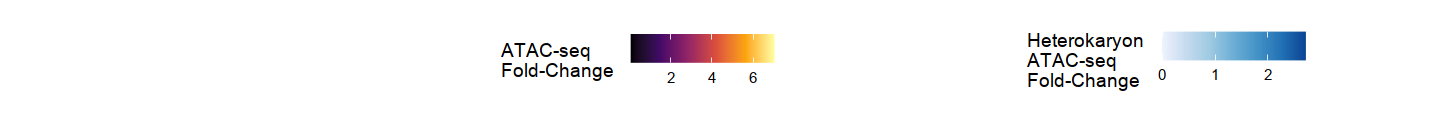

In [291]:
# legends
legend_titles = c("ATAC-seq  \nFold-Change  ",
                 "Heterokaryon   \nATAC-seq  \nFold-Change  ")
legends = list()

for (k in seq(length(unique(vortex_config$type)))) {
    legends[[k]] = cowplot::get_legend(ggplot(data = data.frame(Var1=c(1), Var2=c(1), value=c(1)), 
                   aes(x = Var2, y = Var1, fill = value)) +
            geom_raster() +  
            COLORSCALES[[k]] +
            labs(fill=legend_titles[k]) +
            theme(legend.position = "bottom"))
}

options(repr.plot.width = 12, repr.plot.height = 1)

legend_plot = wrap_plots(plot_spacer(), wrap_plots(legends, nrow=1), widths=c(1,3))
legend_plot

In [ ]:
top_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0,10)) + # this let's use 0-10 on y axis to place items
                annotate("segment", x = 0, xend = 1.1, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = .55, y = 5, size=5, label = "Fibroblasts") +

                annotate("segment", x = 1.2, xend = 5.2, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 3.2, y = 5, size=5, label = "D2") +

                annotate("segment", x = 5.3, xend = 7, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 6.1, y = 5, size=5, label = "D4-D8") +

                annotate("segment", x = 7.1, xend = 8.8, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 8, y = 5, size=5, label = "D10-D24") +

                annotate("segment", x = 8.9, xend = 10, y = 2, yend = 2, size=1, colour = "black")  +
                annotate("text", x = 9.5, y = 5, size=5, label = "iPSC") 
#                 annotate("text", x = 2, y = 25, label = "Some text")

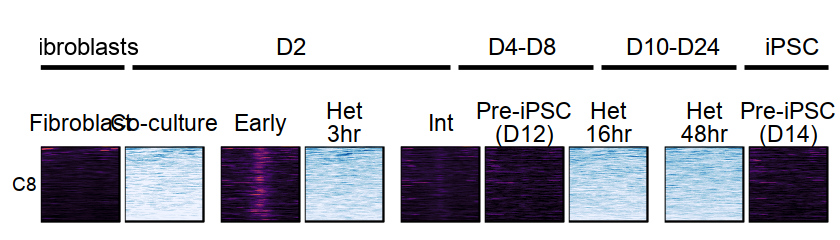

In [113]:
options(repr.plot.width = 7, repr.plot.height = 2)

wrap_plots(top_annotate_plot,
           rowwise_plots[[1]],
           heights=c(1,1))

In [303]:
left_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0.5,9.5)) + # this let's use 0-10 on y axis to place items
#                 annotate("segment", x = 8, xend = 8, y = 0, yend = 3.4, size=1, colour = "black") +
                annotate("text", x = 7, y =1.9, size=5, angle=90, label = "Late Open") +

#                 annotate("segment", x = 8, xend = 8, y = 3.5, yend = 6.7, size=1, colour = "black") +
                annotate("text", x = 7, y = 4.9, size=5, angle=90, label = "Early Open") +

#                 annotate("segment", x = 8, xend = 8, y = 6.8, yend = 10, size=1, colour = "black")  +
                annotate("text", x = 7, y = 8, size=5, angle=90, label = "Transient") 
#                 annotate("text", x = 2, y = 25, label = "Some text")

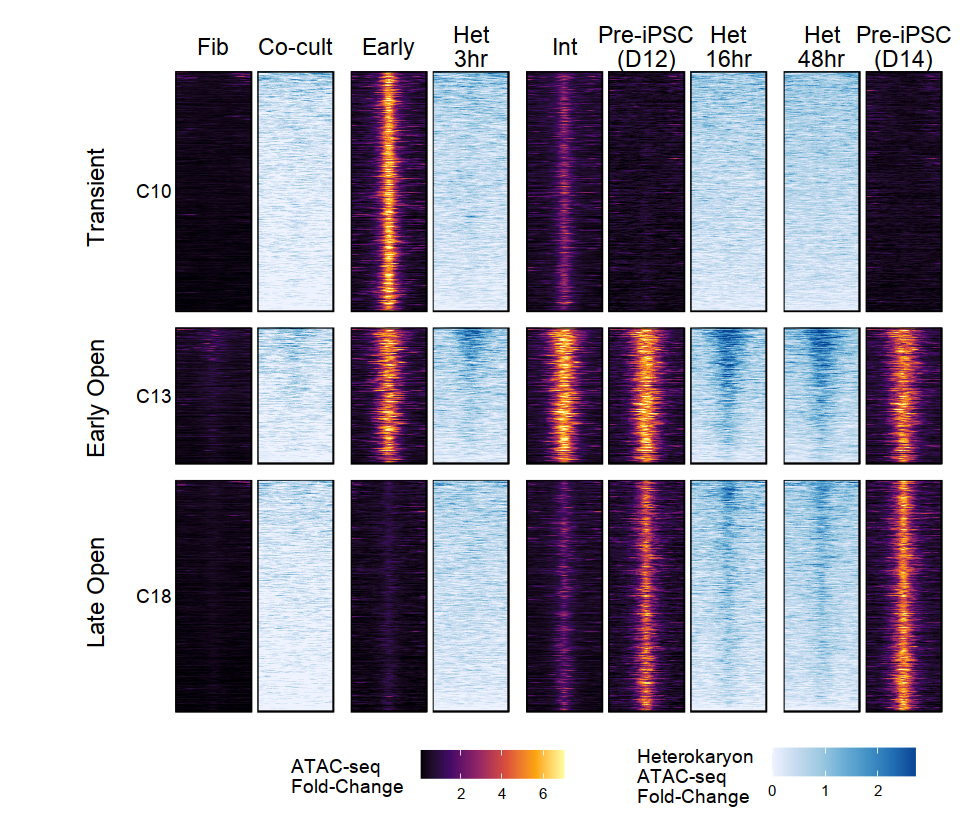

In [304]:
options(repr.plot.width = 8, repr.plot.height = 7)
vortex_grid = wrap_plots(
    rowwise_plots,
    ncol=1,
    heights = col_heights)

vortex_grid_w_left_anno = wrap_plots(left_annotate_plot, 
                                     vortex_grid,
                                    widths=c(1,7))

# top_annotate_plot_w_space = wrap_plots(plot_spacer(),
#                                        top_annotate_plot,
#                                       widths=c(1.3,6.7)) # adjust to account for cluster numbers text

complete_plot = wrap_plots(#top_annotate_plot_w_space,
                                        vortex_grid_w_left_anno,
                                        legend_plot,
                                        heights=c(7, 1))
complete_plot

In [648]:
ggsave("./tmp.pdf", complete_plot, width=13,height=12)

In [305]:
saveRDS(complete_plot, file=sprintf("./subfigs/%s_vortex.rds",
                                format(Sys.Date(), "%Y%m%d")))

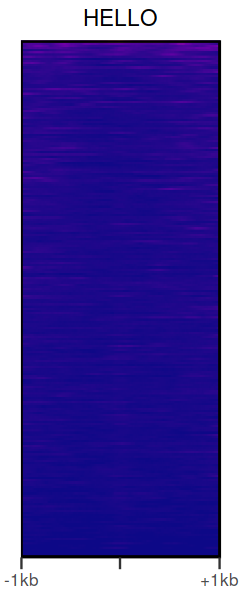

In [245]:
options(repr.plot.width = 2, repr.plot.height = 5)
plot_vortex(smoothed_matrices[[1]][[1]], 
            COLORSCALES[[as.numeric(vortex_config[1, "type"])]], 
            title="HELLO", ticks=1)